### imports


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

%matplotlib inline

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import io
import requests
import shutil
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn import metrics

## Helper functions

In [16]:

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

    # Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [17]:
path = "/Users/pavan/Desktop/ai 2nd pro"
csvfile = os.path.join(path,"AAPL.csv") 
df_stock = pd.read_csv(csvfile)

#print first and last 5 rows in new csv file 
print(df_stock.head())
print(df_stock.tail())

print("\nNumber of columns and row currently:")
print("Data: ", df_stock.shape)

         Date      Open      High       Low     Close  Adj Close       Volume
0  1980-12-12  0.513393  0.515625  0.513393  0.513393   0.023186  117258400.0
1  1980-12-15  0.488839  0.488839  0.486607  0.486607   0.021977   43971200.0
2  1980-12-16  0.453125  0.453125  0.450893  0.450893   0.020364   26432000.0
3  1980-12-17  0.462054  0.464286  0.462054  0.462054   0.020868   21610400.0
4  1980-12-18  0.475446  0.477679  0.475446  0.475446   0.021473   18362400.0
            Date        Open        High         Low       Close   Adj Close  \
9551  2018-10-26  215.899994  220.190002  212.669998  216.300003  216.300003   
9552  2018-10-29  219.190002  219.690002  206.089996  212.240005  212.240005   
9553  2018-10-30  211.149994  215.179993  209.270004  213.300003  213.300003   
9554  2018-10-31  216.880005  220.449997  216.619995  218.860001  218.860001   
9555  2018-11-01  219.050003  222.360001  216.809998  222.220001  222.220001   

          Volume  
9551  47258400.0  
9552  4593550

### Drop missing values and columns 

In [18]:
# Storing in a different dataframe before dropping the columns
df_newstock= df_stock

# Drop rows if there are any missing values
df_newstock.isnull().all(axis=1)
df_newstock = df_newstock.dropna()

# Dropping the columns Date and Adj_Close as mentioned
df_newstock=df_newstock.drop(['Date', 'Adj Close'], axis=1)

#print first 5 rows in new csv file
print(df_newstock.head())


print("\nNumber of col/row currently:")
print("Data: ", df_newstock.shape)

#data about count of NaN in each column
print("\ncount of NaN in each column")
print(df_newstock.isnull().sum())

       Open      High       Low     Close       Volume
0  0.513393  0.515625  0.513393  0.513393  117258400.0
1  0.488839  0.488839  0.486607  0.486607   43971200.0
2  0.453125  0.453125  0.450893  0.450893   26432000.0
3  0.462054  0.464286  0.462054  0.462054   21610400.0
4  0.475446  0.477679  0.475446  0.475446   18362400.0

Number of col/row currently:
Data:  (9555, 5)

count of NaN in each column
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [19]:
# creating a copy of the column, Close
df_newstock['y'] = df_newstock['Close']
#print first 5 rows in new csv file
print(df_newstock.head())

print("\nNumber of col/row currently:")
print("Data: ", df_newstock.shape)

       Open      High       Low     Close       Volume         y
0  0.513393  0.515625  0.513393  0.513393  117258400.0  0.513393
1  0.488839  0.488839  0.486607  0.486607   43971200.0  0.486607
2  0.453125  0.453125  0.450893  0.450893   26432000.0  0.450893
3  0.462054  0.464286  0.462054  0.462054   21610400.0  0.462054
4  0.475446  0.477679  0.475446  0.475446   18362400.0  0.475446

Number of col/row currently:
Data:  (9555, 6)


In [20]:
# creating a copy of the column, Close
df_newstock['y'] = df_newstock['Close']
#print first 5 rows in new csv file
print(df_newstock.head())

print("\nNumber of col/row currently:")
print("Data: ", df_newstock.shape)

       Open      High       Low     Close       Volume         y
0  0.513393  0.515625  0.513393  0.513393  117258400.0  0.513393
1  0.488839  0.488839  0.486607  0.486607   43971200.0  0.486607
2  0.453125  0.453125  0.450893  0.450893   26432000.0  0.450893
3  0.462054  0.464286  0.462054  0.462054   21610400.0  0.462054
4  0.475446  0.477679  0.475446  0.475446   18362400.0  0.475446

Number of col/row currently:
Data:  (9555, 6)


### NORMALIZE NUMERICAL FEATURES

In [21]:
#Normalizing except  last column y
for column in df_newstock.columns:
  if  column != 'y':
    encode_numeric_zscore(df_newstock, column)

#print first  5 rows in new csv file to check for normalizing
print(df_newstock.head())

       Open      High       Low     Close    Volume         y
0 -0.547665 -0.548357 -0.546670 -0.547549  0.339526  0.513393
1 -0.548200 -0.548935 -0.547258 -0.548132 -0.503884  0.486607
2 -0.548977 -0.549706 -0.548042 -0.548909 -0.705730  0.450893
3 -0.548782 -0.549465 -0.547797 -0.548666 -0.761218  0.462054
4 -0.548491 -0.549176 -0.547503 -0.548374 -0.798597  0.475446


In [22]:
# Set all column other than y as input or 'x'
x = df_newstock.iloc[:,df_newstock.columns != 'y']
x = np.array(x, dtype=np.float32)

# Set the y column as output or 'y'
y = np.array(df_newstock['y'].values, dtype=np.float32)
print(x.shape)
print(y.shape)

(9555, 5)
(9555,)


In [23]:
import numpy as np

def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [24]:
SEQUENCE_SIZE = 1
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)
x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of x_lstseq: {}".format(x_lstseq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))

Shape of x_lstseq: (9554, 1, 1, 5)
Shape of y_lstseq: (9554,)


In [25]:
#reshaping the array
x_seq= x_lstseq.reshape(9554,5)


# Split train and test date 70/30

In [26]:
##Split train and test date 70/30
x_train, x_test, y_train, y_test = train_test_split(x_seq, y_lstseq, test_size=0.3, random_state=0)

print("Shape of x_train :{}".format(x_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))

print("Shape of y_train :{}".format(y_train.shape))
print("Shape of y_test  :{}".format(y_test.shape))

type(x_test),type(y_test),type(x_train),type(y_train)


Shape of x_train :(6687, 5)
Shape of x_test  :(2867, 5)
Shape of y_train :(6687,)
Shape of y_test  :(2867,)


(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

# NEURAL NETWORKS


Optimizer  used:  adam  Activation Function used :  relu
Train on 6687 samples, validate on 2867 samples
Epoch 1/200
6687/6687 - 2s - loss: 957.4064 - val_loss: 15.4772
Epoch 2/200
6687/6687 - 0s - loss: 8.7726 - val_loss: 3.0617
Epoch 3/200
6687/6687 - 0s - loss: 1.4426 - val_loss: 0.9082
Epoch 4/200
6687/6687 - 0s - loss: 0.8370 - val_loss: 0.7965
Epoch 5/200
6687/6687 - 0s - loss: 0.7885 - val_loss: 0.7335
Epoch 6/200
6687/6687 - 0s - loss: 0.7608 - val_loss: 0.7915
Epoch 7/200
6687/6687 - 0s - loss: 0.7632 - val_loss: 0.7280
Epoch 8/200
6687/6687 - 0s - loss: 0.7579 - val_loss: 0.8941
Epoch 9/200
6687/6687 - 0s - loss: 0.7986 - val_loss: 0.7730
Epoch 10/200
6687/6687 - 0s - loss: 0.8117 - val_loss: 0.8444
Epoch 11/200
6687/6687 - 0s - loss: 0.7834 - val_loss: 0.7557
Epoch 12/200
6687/6687 - 0s - loss: 0.7966 - val_loss: 0.7279
Epoch 00012: early stopping
Score_train (RMSE): 0.841701090335846
Score_test (RMSE): 0.8531692624092102


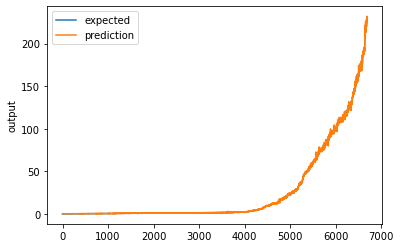

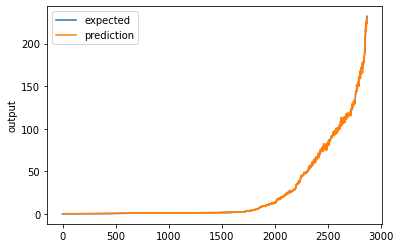

Optimizer  used:  adam  Activation Function used :  sigmoid
Train on 6687 samples, validate on 2867 samples
Epoch 1/200
6687/6687 - 2s - loss: 2664.3585 - val_loss: 2326.6878
Epoch 2/200
6687/6687 - 0s - loss: 2468.6115 - val_loss: 2182.7099
Epoch 3/200
6687/6687 - 0s - loss: 2346.2443 - val_loss: 2088.8479
Epoch 4/200
6687/6687 - 0s - loss: 2262.0470 - val_loss: 1968.9262
Epoch 5/200
6687/6687 - 0s - loss: 2002.4646 - val_loss: 1687.7319
Epoch 6/200
6687/6687 - 0s - loss: 1798.0630 - val_loss: 1519.2039
Epoch 7/200
6687/6687 - 0s - loss: 1635.6476 - val_loss: 1376.5393
Epoch 8/200
6687/6687 - 0s - loss: 1495.1506 - val_loss: 1253.2334
Epoch 9/200
6687/6687 - 0s - loss: 1371.0242 - val_loss: 1142.6262
Epoch 10/200
6687/6687 - 0s - loss: 1259.4386 - val_loss: 1044.6514
Epoch 11/200
6687/6687 - 0s - loss: 1158.6267 - val_loss: 955.0017
Epoch 12/200
6687/6687 - 0s - loss: 1067.1424 - val_loss: 876.0560
Epoch 13/200
6687/6687 - 0s - loss: 983.8532 - val_loss: 802.6266
Epoch 14/200
6687/668

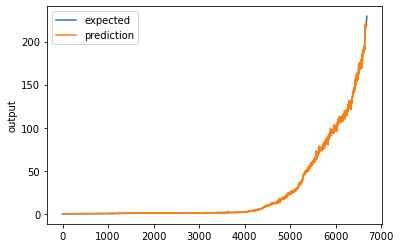

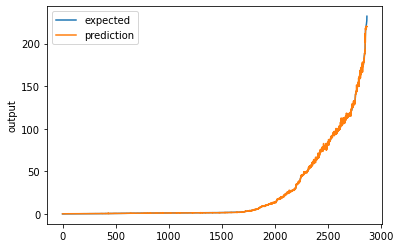

Optimizer  used:  adam  Activation Function used :  tanh
Train on 6687 samples, validate on 2867 samples
Epoch 1/200
6687/6687 - 2s - loss: 2439.3934 - val_loss: 2017.6296
Epoch 2/200
6687/6687 - 0s - loss: 2097.9078 - val_loss: 1772.2509
Epoch 3/200
6687/6687 - 0s - loss: 1867.3190 - val_loss: 1567.6059
Epoch 4/200
6687/6687 - 0s - loss: 1666.4710 - val_loss: 1388.1498
Epoch 5/200
6687/6687 - 0s - loss: 1487.5950 - val_loss: 1228.8145
Epoch 6/200
6687/6687 - 0s - loss: 1329.5088 - val_loss: 1089.6109
Epoch 7/200
6687/6687 - 0s - loss: 1189.1911 - val_loss: 966.9959
Epoch 8/200
6687/6687 - 0s - loss: 1064.5509 - val_loss: 859.0622
Epoch 9/200
6687/6687 - 0s - loss: 953.5595 - val_loss: 763.3913
Epoch 10/200
6687/6687 - 0s - loss: 854.6176 - val_loss: 680.0609
Epoch 11/200
6687/6687 - 0s - loss: 766.4800 - val_loss: 604.5591
Epoch 12/200
6687/6687 - 0s - loss: 687.6106 - val_loss: 538.8085
Epoch 13/200
6687/6687 - 0s - loss: 616.9314 - val_loss: 480.3365
Epoch 14/200
6687/6687 - 0s - lo

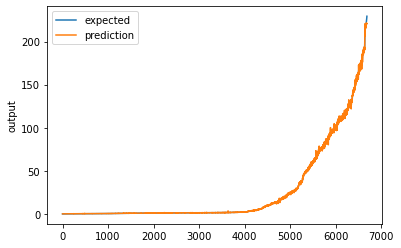

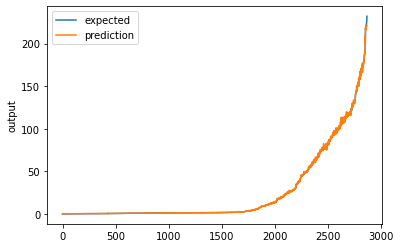

Optimizer  used:  sgd  Activation Function used :  relu
Train on 6687 samples, validate on 2867 samples
Epoch 1/200
6687/6687 - 1s - loss: nan - val_loss: nan
Epoch 2/200
6687/6687 - 0s - loss: nan - val_loss: nan
Epoch 3/200
6687/6687 - 0s - loss: nan - val_loss: nan
Epoch 4/200
6687/6687 - 0s - loss: nan - val_loss: nan
Epoch 5/200
6687/6687 - 0s - loss: nan - val_loss: nan
Epoch 00005: early stopping
Score_train (RMSE): 295.7110900878906
Score_test (RMSE): 285.6061096191406


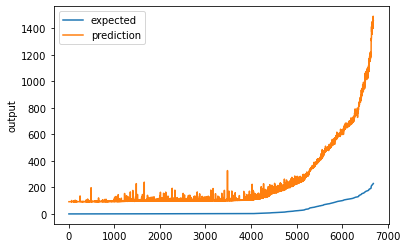

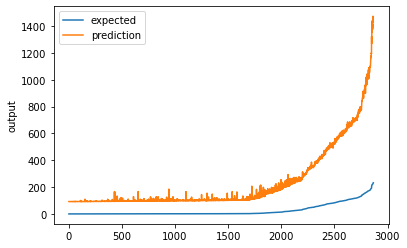

Optimizer  used:  sgd  Activation Function used :  sigmoid
Train on 6687 samples, validate on 2867 samples
Epoch 1/200
6687/6687 - 2s - loss: 884.7997 - val_loss: 191.4242
Epoch 2/200
6687/6687 - 0s - loss: 189.2290 - val_loss: 85.3549
Epoch 3/200
6687/6687 - 0s - loss: 178.4076 - val_loss: 148.2299
Epoch 4/200
6687/6687 - 0s - loss: 398.5664 - val_loss: 985.5933
Epoch 5/200
6687/6687 - 0s - loss: 502.1502 - val_loss: 435.8397
Epoch 6/200
6687/6687 - 0s - loss: 312.7497 - val_loss: 104.8389
Epoch 7/200
6687/6687 - 0s - loss: 139.5267 - val_loss: 101.9068
Epoch 00007: early stopping
Score_train (RMSE): 9.597661018371582
Score_test (RMSE): 9.23877239227295


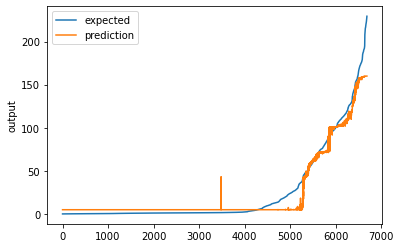

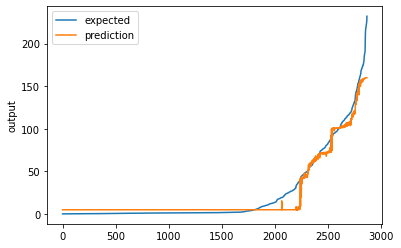

Optimizer  used:  sgd  Activation Function used :  tanh
Train on 6687 samples, validate on 2867 samples
Epoch 1/200
6687/6687 - 2s - loss: 517.9642 - val_loss: 225.4106
Epoch 2/200
6687/6687 - 0s - loss: 349.5628 - val_loss: 411.7953
Epoch 3/200
6687/6687 - 0s - loss: 1613.4838 - val_loss: 1972.1138
Epoch 4/200
6687/6687 - 0s - loss: 2203.6185 - val_loss: 2141.0340
Epoch 5/200
6687/6687 - 0s - loss: 2200.0792 - val_loss: 2005.3851
Epoch 6/200
6687/6687 - 0s - loss: 2206.2838 - val_loss: 2017.5258
Epoch 00006: early stopping
Score_train (RMSE): 16.203088760375977
Score_test (RMSE): 15.01368236541748


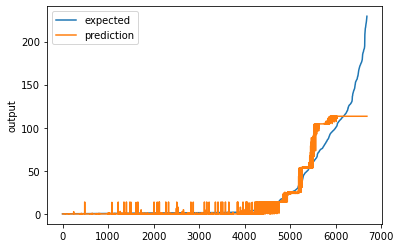

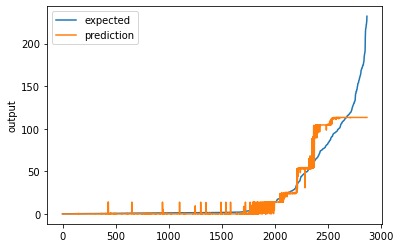

In [27]:
# List of posible activation functions
activation_functions = ['relu','sigmoid','tanh']
# List of posible optimizers
optimizers = ['adam','sgd']

# Loop through all combination of optimizers and activation functions
for optimizer in optimizers:
  for activ_function in activation_functions:
    print("Optimizer  used: ", optimizer, " Activation Function used : ", activ_function)

    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation=activ_function))
    model.add(Dense(32,activation=activ_function))
    model.add(Dense(32,activation=activ_function))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)

    model.load_weights('best_weights_NN.hdf5')  


    pred_train = model.predict(x_train)
    score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
    print("Score_train (RMSE): {}".format(score_train))

    pred_test = model.predict(x_test)
    score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
    print("Score_test (RMSE): {}".format(score_test))

    
    #chart_regression(pred.flatten(),y_lstseqtest, sort=True)
    chart_regression(pred_train.flatten(),y_train, sort=True)
    chart_regression(pred_test.flatten(),y_test, sort=True) 